### Неделя 4. Прогнозирование большого количества рядов

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from itertools import product
from sklearn import cross_validation, linear_model, metrics
import scipy.cluster.hierarchy as sch

Populating the interactive namespace from numpy and matplotlib


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\JB\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### 1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016! 

In [2]:
# подготовил предварительно данные по 102 ячейкам за январь - апрель 2016
data = pd.read_csv('data2014-2016_m4_102cell.csv', sep=';', header=0, index_col=['date_hour'], 
                  parse_dates=['date_hour'], dayfirst=True)

In [3]:
data.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,87,146,70,113,367,645,589,799,948,321,...,9,0,5,89,10,35,9,106,22,71
2014-01-01 01:00:00,92,184,93,153,539,604,490,635,667,225,...,24,0,3,22,2,5,0,87,0,44


In [4]:
len(data)

20423

##### 2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [4]:
data_norm = data.copy()
for i in range(len(data.columns)):
    data_norm[data.columns[i]] = (data[data.columns[i]] - data[data.columns[i]].mean())/data[data.columns[i]].std()

In [6]:
data_norm.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.513983,0.095196,-0.353265,0.938354,1.535529,2.136306,1.288134,1.841018,1.781473,1.889992,...,0.684813,-0.872965,-0.408468,-0.756570,-1.209861,-0.860160,-0.031320,-0.346684,-0.578707,0.316548
2014-01-01 01:00:00,0.633956,0.554651,0.005961,1.873884,3.136857,1.880833,0.777699,1.107496,0.756177,0.790655,...,3.629677,-0.872965,-0.732165,-1.186321,-1.271174,-1.385054,-1.109988,-0.605104,-1.270152,-0.435323


##### 3.Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

Wall time: 3.15 s


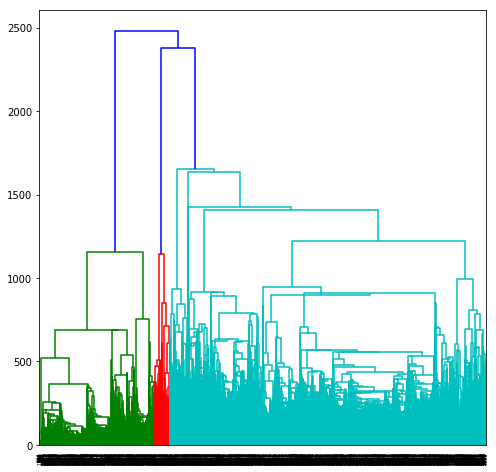

In [7]:
%%time
# построим дендрограмму чтобы понять сколько кластеров строить
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))
Y = sch.linkage(data[17519:].values, method='centroid')
Z1 = sch.dendrogram(Y, orientation='top')

судя по дендрограмме надо брать или 3 или 9 кластеров, попробуем 9 для большей точности

In [8]:
data.values.shape

(20423L, 102L)

In [6]:
# возьмем для классификации метод k-means
n_clust = 9 # количество кластеров
from sklearn.cluster import KMeans
KM_model = KMeans(n_clusters=n_clust, random_state=1)
preds = KM_model.fit_predict(data_norm.values.transpose())  # транспонирую данные т.к. k-means работает по строкам

In [7]:
# для удобства сделаю датафрейм с ячейками и кластерами
df_clust = pd.DataFrame(data.columns)
df_clust['cluster'] = preds
df_clust.columns = ['cell', 'cluster']
df_clust['coef_d'] = 0 # столбец для коэф-тов детерминации

In [8]:
df_clust.iloc[0:5]

,cell,cluster,coef_d
0,1075,5,0
1,1076,2,0
2,1077,2,0
3,1125,0,0
4,1126,0,0


In [12]:
# посмотрим на результаты кластеризации
preds

array([5, 2, 2, 0, 0, 0, 0, 0, 6, 0, 5, 1, 1, 3, 3, 6, 6, 0, 0, 0, 2, 0, 2,
       2, 1, 1, 1, 1, 1, 6, 6, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 2, 2, 0, 5,
       5, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 2, 2, 2, 5, 3, 6, 6, 6, 1, 5, 2, 2,
       2, 2, 3, 3, 3, 3, 6, 3, 2, 3, 3, 3, 3, 3, 3, 3, 8, 4, 8, 8, 4, 4, 8,
       4, 5, 5, 5, 5, 7, 7, 7, 7, 7])

In [13]:
# массив с центрами кластеров (взял из 4-го пункта) и цветами графиков
arr_centr_cell = ['1230', '1272', '1333','1387','1533','1283','1326','2118','1530']
arr_color = ['b.','r.','g.','m.','y.','c.','k.','b.','r.']

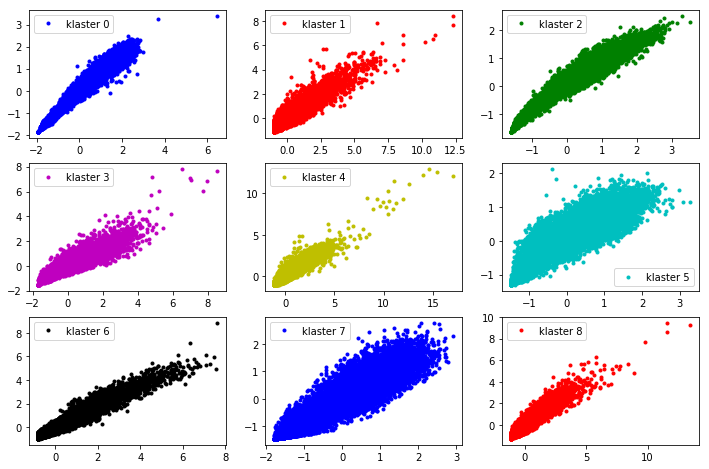

In [14]:
#нарисуем данные для визуального анализа, ближайшую к центру ячейку из кластера и его центральный ряд
# при хорошей кластеризации график будет вытянут вдоль диагонали
plt.figure(figsize(12,8))
for i in range(len(arr_centr_cell)):
    pyplot.subplot(3, 3, i+1)
    plot(data_norm[arr_centr_cell[i]].values, KM_model.cluster_centers_[i], arr_color[i], label='klaster '+str(i))
    plt.legend()

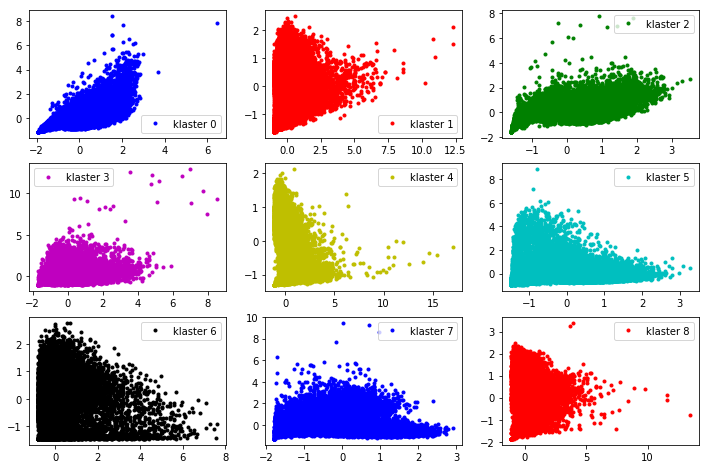

In [15]:
# для сравнения сдвину центры кластеров на 1 и посмотрю так-же хорошо график выглядит или нет
plt.figure(figsize(12,8))
for i in range(len(arr_centr_cell)):
    if i < 8: j=i+1
    else: j=0
    pyplot.subplot(3, 3, i+1)
    plot(data_norm[arr_centr_cell[i]].values, KM_model.cluster_centers_[j], arr_color[i], label='klaster '+str(i))
    plt.legend()

Видно что графики расплылись от диагонали, появились разрывы, считаю что классификация проведена хорошо. 
Хотелось бы еще численно оценить итоги классификации

##### 4.В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера). 

In [16]:
# найдем ячейки которые ближе всего к центрам кластеров, считаю максимальный коэф-т детерминации
int_s = 0
cl_name = ''
k=0
for i in range(n_clust):
    int_s = 0
    for j in range(len(data_norm.columns)):
        if i == df_clust.cluster.iloc[j]:  # если номер кластера соответсвует текущему центру
            k = metrics.r2_score(data_norm[data_norm.columns[j]].values, KM_model.cluster_centers_[i])
            df_clust['coef_d'].iloc[j] = k
            if (int_s < k): 
                int_s = k
                cl_name = data_norm.columns[j]
    print 'cluster: ' + str(i) + '   cell: ' + cl_name + ' макс коэф-т детерминации: ' + str(int_s)

cluster: 0   cell: 1230 макс коэф-т детерминации: 0.950945702872
cluster: 1   cell: 1272 макс коэф-т детерминации: 0.814482965658
cluster: 2   cell: 1333 макс коэф-т детерминации: 0.946142300452
cluster: 3   cell: 1387 макс коэф-т детерминации: 0.794952039379
cluster: 4   cell: 1533 макс коэф-т детерминации: 0.841749728627
cluster: 5   cell: 1283 макс коэф-т детерминации: 0.842872774467
cluster: 6   cell: 1326 макс коэф-т детерминации: 0.928628107774
cluster: 7   cell: 2118 макс коэф-т детерминации: 0.836975493962
cluster: 8   cell: 1530 макс коэф-т детерминации: 0.879266391699


C:\Users\JB\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
# посмотрим на самые дальние ячейки от центров кластеров, считаю минимальный коэф-т детерминации
int_s = 0
cl_name = ''
k=0
for i in range(n_clust):
    int_s = 1
    for j in range(len(data_norm.columns)):
        if i == df_clust.cluster.iloc[j]:  # если номер кластера соответсвует текущему центру
            k = metrics.r2_score(data_norm[data_norm.columns[j]].values, KM_model.cluster_centers_[i])
#            df_clust['coef_d'].iloc[j] = k
            if (int_s > k): 
                int_s = k
                cl_name = data_norm.columns[j]
    print 'cluster: ' + str(i) + '   cell: ' + cl_name + ' мин коэф-т детерминации: ' + str(int_s)

cluster: 0   cell: 1129 мин коэф-т детерминации: 0.663926386248
cluster: 1   cell: 1278 мин коэф-т детерминации: 0.442529341215
cluster: 2   cell: 1183 мин коэф-т детерминации: 0.494544207311
cluster: 3   cell: 1431 мин коэф-т детерминации: 0.162723140058
cluster: 4   cell: 1630 мин коэф-т детерминации: 0.643152879008
cluster: 5   cell: 1132 мин коэф-т детерминации: 0.378182498924
cluster: 6   cell: 1176 мин коэф-т детерминации: 0.622954436088
cluster: 7   cell: 2069 мин коэф-т детерминации: 0.593204469987
cluster: 8   cell: 1480 мин коэф-т детерминации: 0.753364930964


отрицательных коэфициентов нет, уже хорошо

In [18]:
# посчитаю средний коэф-т деерминации, 0.74 очень даже неплохо 
df_clust['coef_d'].mean()

0.7392515769395654

##### строим модель для:
1. cluster:  cell: 1230
2. cluster:  cell: 1272
3. cluster:  cell: 1333
4. cluster:  cell: 1387
5. cluster:  cell: 1533
6. cluster:  cell: 1283
7. cluster:  cell: 1326
8. cluster:  cell: 2118
9. cluster:  cell: 1530

##### 5.Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Qp,d,q,P,D,Qp,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016! 

In [19]:
len(data)

20423

In [20]:
data.iloc[17518:17520]

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2015-12-31 23:00:00,48,103,40,54,186,334,347,446,505,133,...,10,0,3,131,50,75,1,162,52,97
2016-01-01 00:00:00,80,144,50,77,319,402,531,617,846,267,...,12,0,2,44,5,41,4,70,7,66


In [161]:
# в data_ostatki буду хранить остатки от регрессии
data_ostatki = data.copy()
data_ostatki.drop(data_ostatki[data_ostatki.index < '2016-01-01 00:00:00'].index, inplace=True)
len(data_ostatki)

2904

настрою регрессию за 2 года 2014 и 2015, на 4 месяцах 2016 сделаю тест, АРИМУ буду обучать на остатки регрессии

In [162]:
# Создадим регрессионные признаки для учёта сезонностей и трендов.
#Si=sin([1,…,T]∗2πi/168),Ci=cos([1,…,T]∗2πi/168),i=1,…,K.
# для теста регрессии возьму январь-апрель 2016 , 2904 длина моделируемого ряда 
# К возьму 111
itog_param = []
temp_param = []
K=111
arr_param = np.zeros((20423,222), dtype=float)

for j in range(K):
    temp_param = []
    for i in range(len(arr_param)):    
        arr_param[i,j*2] = sin((i+1)*2*np.pi*(j+1)/168.)
        arr_param[i,j*2+1] = cos((i+1)*2*np.pi*(j+1)/168.)

In [163]:
%%time
# Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, 
#сделайте регрессию целевого признака — количества поездок — на построенные признаки. 
#Посмотрите на остатки регрессии.
# Построю SGD регрессию по признакам и посмотрю на остатки 
# трейн сделаю за 2 года, а тест на январь-апрель 2016
X_train = arr_param[:17519] # 17519
y_train = data['1684'].iloc[:17519].values
X_test = arr_param[17519:]
y_test = data['1684'].iloc[17519:].values

# SGD регрессия
clf_SGD = linear_model.SGDRegressor()

clf_SGD.fit(X_train, y_train)
pred_SGD = clf_SGD.predict(X_test)
score_SGD = clf_SGD.score(X_test, y_test)

# Create linear regression object
clf_LIN = linear_model.LinearRegression()
clf_LIN.fit(X_train, y_train)
pred_LIN = clf_LIN.predict(X_test)
score_LIN = clf_LIN.score(X_test, y_test)

ostatki = y_test-pred_LIN

data_ostatki['1684_ost'] = ostatki

print 'точность модели SGD регрессии ' + str(score_SGD)
print 'точность модели linear regression ' + str(score_LIN)

точность модели SGD регрессии 0.461247498054
точность модели linear regression 0.480588967854
Wall time: 203 ms


In [307]:
# у линейной модели немного выше точность дальше буду использовать ее

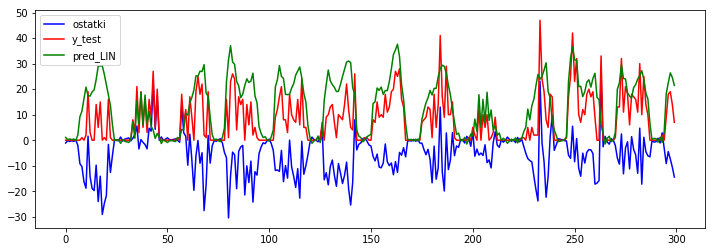

In [164]:
# посмотрим на остатки
plt.figure(figsize(12,4))
plot(ostatki[:300], 'b', label='ostatki')
plot(y_test[:300], 'r', label='y_test')
plot(pred_LIN[:300], 'g', label='pred_LIN')
plt.legend()

Критерий Дики-Фуллера: p=0.000000


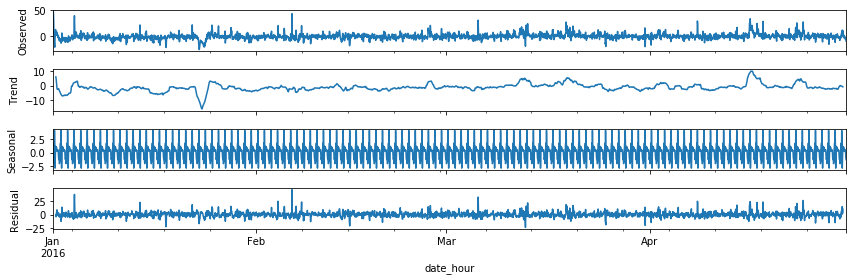

In [26]:
# попробуем продифференцировать остатки
# еще раз построим STL-декомпозицию ряда и посчитаем критерий Дики-Фуллера теперь по остаткам

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_ostatki['1530_ost'])[1])
plt.figure(figsize=(20,8))
sm.tsa.seasonal_decompose(data_ostatki['1530_ost']).plot()
plt.show()

остатки около 0, Дики-Фуллер 0 все хорошо переходим в АРИМА

In [165]:
# возьмем начальные параметры модели как и на прошлой неделе, модель строю на периоде 24 часа
# exog модель не улучшал и замедлял обучение, поэтому не буду его использовать, обучаю на остатках регрессии
ps = range(0, 4)
d=0
qs = range(0, 2)
Ps = range(0, 2)
D=0
Qs = range(0, 2)

In [166]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
#parameters_list

32

In [167]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_ostatki['1684_ost'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=False) #, exog=exog_
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError: 
        print('Singular matrix, wrong parameters:', param)
        continue
        
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 1, 0, 0))
('wrong parameters:', (1, 1, 0, 1))
('wrong parameters:', (1, 1, 1, 0))
('wrong parameters:', (1, 1, 1, 1))
Wall time: 1min 5s


In [30]:
model.params

ar.L1        1.302220
ar.L2       -0.271707
ar.L3       -0.056832
ma.L1       -0.897172
ar.S.L24     0.992394
ma.S.L24    -0.958868
sigma2      23.817649
dtype: float64

In [168]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
18  (2, 1, 1, 1)  20399.997941
26  (3, 1, 1, 1)  20401.367905
22  (3, 0, 1, 1)  20421.129605
14  (2, 0, 1, 1)  20444.407873
10  (1, 0, 1, 1)  20479.364202


##### после отбора параметров для SARIMA строим модель на d=0 D=0 и p,q,P,Q:
0. cluster 0:  cell: 1230   гип-параметры 3 1 1 1
1. cluster 1:  cell: 1272   гип-параметры 1 1 1 1
2. cluster 2:  cell: 1333   гип-параметры 3 0 1 1
3. cluster 3:  cell: 1387   гип-параметры 3 1 1 1
4. cluster 4:  cell: 1533   гип-параметры 2 0 1 1
5. cluster 5:  cell: 1283   гип-параметры 1 1 1 1
6. cluster 6:  cell: 1326   гип-параметры 2 0 1 1
7. cluster 7:  cell: 2118   гип-параметры 3 1 1 1
8. cluster 8:  cell: 1530   гип-параметры 3 1 1 1

In [9]:
# сделаю массив с гипер-параметрами
arr_gip = [[3,1,1,1],[1,1,1,1],[3,0,1,1],[3,1,1,1],[2,0,1,1],[2,1,1,1],[2,0,1,1],[3,1,1,1],[3,1,1,1]]

6.Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу: Qmay=R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117.......

In [10]:
# загрузим данные за январь - июнь 2016 года
# подготовил предварительно данные по 102 ячейкам за январь - апрель 2016
data_06 = pd.read_csv('data2016_m1_m6_102cell.txt', sep=';', header=0, index_col=['date_hour'], 
                  parse_dates=['date_hour'], dayfirst=True)

In [11]:
data_06.iloc[2903:2905] # 2904 2016-05-01 00:00:00 may  .. june 3648 2016-06-01 00:00:00

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39
2016-05-01 00:00:00,71,64,52,81,259,535,691,994,1100,193,...,7,0,3,60,94,42,7,146,4,85


In [12]:
data_06.shape

(4368, 102)

In [42]:
# датафрейм для обучения регрессии
data.iloc[20421:20423]

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2016-04-30 22:00:00,100,97,85,100,217,421,697,955,909,203,...,1,0,2,230,80,132,21,198,23,93
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39


In [43]:
data.shape

(20423, 102)

In [37]:
df_clust.iloc[0:4]

,cell,cluster,coef_d
0,1075,5,0.754951
1,1076,2,0.802455
2,1077,2,0.808401
3,1125,0,0.789695


In [13]:
# в data_ostatki буду хранить остатки от регрессии
#data_ostatki = pd.DataFrame()
data_ostatki = data_06.copy()
data_ostatki.drop(data_ostatki[data_ostatki.index > '2016-05-31 23:00:00'].index, inplace=True)
len(data_ostatki)

3648

In [66]:
#data_ostatki.iloc[:3648]  январь - май 2016
#data_ostatki.iloc[:2904]  январь - апрель 2016 

In [172]:
# Создадим регрессионные признаки для учёта сезонностей и трендов.
#Si=sin([1,…,T]∗2πi/168),Ci=cos([1,…,T]∗2πi/168),i=1,…,K.
# для теста регрессии возьму январь-май 2016 , 2904 длина моделируемого ряда, 20423 по 04.2016, май 744, июнь 720
# 21887 всего, 21167 до мая 2016, 17519 до 01.2016
# К возьму 111
itog_param = []
temp_param = []
K=111
arr_param = np.zeros((21887,222), dtype=float)

for j in range(K):
    temp_param = []
    for i in range(len(arr_param)):    
        arr_param[i,j*2] = sin((i+1)*2*np.pi*(j+1)/168.)
        arr_param[i,j*2+1] = cos((i+1)*2*np.pi*(j+1)/168.)

In [173]:
%%time
# мега цикл который долго думал как сделать
# зададим период времени для цикла 01 мая 2016
date_index = pd.date_range('04/30/2016 23:00:00', periods=739, freq='H') 

Qmay = 0 # ошибка предсказания за май

for i in range(df_clust.shape[0]):    # цикл на 102 зоны  df_clust.shape[0]

# Обучаем модель на разрешенной выборкe:    
# сначала обучаю линейную регрессию 01.2014 - 12.2015 и делаю предсказание на 01-05.2016
# трейн сделаю за 2 года, а тест на январь-май 2016
    
    X_train = arr_param[:17519] # 17519
    y_train = data[df_clust.cell[i]].iloc[:17519].values
    X_test = arr_param[17519:21167]
    y_test = data_06[df_clust.cell[i]].iloc[:3648].values

    # Create linear regression object
    clf_LIN = linear_model.LinearRegression()
    clf_LIN.fit(X_train, y_train)
    pred_LIN = clf_LIN.predict(X_test)
    score_LIN = clf_LIN.score(X_test, y_test)
    data_ostatki[df_clust.cell[i]+'_prLIN'] = pred_LIN
    data_ostatki[df_clust.cell[i]+'_ost'] = y_test-pred_LIN  # сохраняем остатки от регрессии
    
    # обучаем SARIMAX на параметрах зоны своего кластера  до апреля 2016 включительно #.filter(model.params)
    model_res = sm.tsa.statespace.SARIMAX(data_ostatki[df_clust.cell[i]+'_ost'][:2904], 
                                             order=[arr_gip[df_clust.cluster[i]][0],0,arr_gip[df_clust.cluster[i]][1]],
                                             seasonal_order=[arr_gip[df_clust.cluster[i]][2],0,
                                                             arr_gip[df_clust.cluster[i]][3],24]).fit(disp=False)

    # сохраним и сложим с регрессией то что получилось
#    data_06[df_clust.cell[i]+'_pred'] = model_res.fittedvalues+pred_LIN[:2904]
#    print('Коэффициент детерминации модели зоны '+str(df_clust.cell[i])+ ' : {:.2f}'.format(
#        metrics.r2_score(data_06[df_clust.cell[i]+'_pred'][:3648], data_06[df_clust.cell[i]][:3648])))    
    
#Создаем вторую модель на весь временной интервал выборки
    
    model_fitted = sm.tsa.statespace.SARIMAX(data_ostatki[df_clust.cell[i]+'_ost'][:3648], 
                                             order=[arr_gip[df_clust.cluster[i]][0],0,arr_gip[df_clust.cluster[i]][1]],
                                             seasonal_order=[arr_gip[df_clust.cluster[i]][2],0,
                                                             arr_gip[df_clust.cluster[i]][3],24]
                                            ).filter(model_res.params)

    j=2904 # индекс для вытаскивания предсказания рeгрессии, начинаем с 1 мая 00:00
    for time in date_index:
        predicted_data_S = model_fitted.predict(time, time+6, dynamic=True)
        pred_all_6 = predicted_data_S[1:] + pred_LIN[j:j+6]
        Qmay += sum(abs(data_06[df_clust.cell[i]][time+1:time+6]-pred_all_6))
        j+=1

    print 'зона '+str(i)+'  '+ datetime.datetime.now().strftime('%Y.%m.%d %H:%M:%S')+' Q='+str(1/((i+1)*739*6.)*Qmay)

зона 0  2018.07.18 17:22:10 Q=10.7077480012
зона 1  2018.07.18 17:22:53 Q=13.6241580346
зона 2  2018.07.18 17:23:30 Q=13.207365923
зона 3  2018.07.18 17:24:16 Q=12.5733945146
зона 4  2018.07.18 17:25:10 Q=14.5537056148
зона 5  2018.07.18 17:26:02 Q=17.4942691959
зона 6  2018.07.18 17:26:56 Q=20.5459574307
зона 7  2018.07.18 17:27:48 Q=23.0968600963
зона 8  2018.07.18 17:28:34 Q=26.1272042513
зона 9  2018.07.18 17:29:33 Q=25.8441542234
зона 10  2018.07.18 17:30:05 Q=24.8698495597
зона 11  2018.07.18 17:30:56 Q=23.0509108929
зона 12  2018.07.18 17:31:41 Q=21.8114258873
зона 13  2018.07.18 17:32:36 Q=20.7007914639
зона 14  2018.07.18 17:33:30 Q=19.5869166864
зона 15  2018.07.18 17:34:14 Q=18.6516886936
зона 16  2018.07.18 17:34:45 Q=20.0001312273
зона 17  2018.07.18 17:35:37 Q=21.7106657353
зона 18  2018.07.18 17:36:33 Q=23.3126380282
зона 19  2018.07.18 17:37:28 Q=25.1648557232
зона 20  2018.07.18 17:38:18 Q=27.8284409076
зона 21  2018.07.18 17:39:05 Q=28.8589430241
зона 22  2018.07.18 1

In [175]:
# считаем ошибку прогноза
1/(102*739*6.)*Qmay

19.698735395339913

7.Для каждой из RRR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз. 

In [14]:
# загрузим данные за январь - июнь 2016 года
# подготовил предварительно данные по 102 ячейкам за январь - апрель 2016
data_06 = pd.read_csv('data2016_m1_m6_102cell.txt', sep=';', header=0, index_col=['date_hour'], 
                  parse_dates=['date_hour'], dayfirst=True)

In [15]:
data_06.iloc[3646:3650] # 2904 2016-05-01 00:00:00 may  .. june 3648 2016-06-01 00:00:00

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2016-05-31 22:00:00,83,98,127,94,174,345,415,411,490,144,...,1,20,9,392,299,123,12,222,53,123
2016-05-31 23:00:00,34,77,58,53,118,211,331,338,434,121,...,2,12,10,430,153,157,17,192,77,132
2016-06-01 00:00:00,26,30,19,39,71,163,181,219,326,56,...,1,1,6,262,107,114,7,169,6,85
2016-06-01 01:00:00,14,21,6,26,49,101,136,144,252,27,...,5,0,0,137,1,27,16,105,4,42


In [16]:
# датафрейм для обучения регрессии
data.iloc[20421:20423]

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date_hour,,,,,,,,,,,,,,,,,,,,,
2016-04-30 22:00:00,100,97,85,100,217,421,697,955,909,203,...,1,0,2,230,80,132,21,198,23,93
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39


In [17]:
# в data_ostatki буду хранить остатки от регрессии
#data_ostatki = pd.DataFrame()
data_ostatki = data_06.copy()
#data_ostatki.drop(data_ostatki[data_ostatki.index > '2016-05-31 23:00:00'].index, inplace=True)
len(data_ostatki)

4368

In [18]:
# Создадим регрессионные признаки для учёта сезонностей и трендов.
#Si=sin([1,…,T]∗2πi/168),Ci=cos([1,…,T]∗2πi/168),i=1,…,K.
# для теста регрессии возьму январь-июнь 2016 , 4368 длина моделируемого ряда, 20423 по 04.2016, май 744, июнь 720
# 21887 всего, 21167 до мая 2016, 17519 до 01.2016
# К возьму 111
itog_param = []
temp_param = []
K=111
arr_param = np.zeros((21887,222), dtype=float)

for j in range(K):
    temp_param = []
    for i in range(len(arr_param)):    
        arr_param[i,j*2] = sin((i+1)*2*np.pi*(j+1)/168.)
        arr_param[i,j*2+1] = cos((i+1)*2*np.pi*(j+1)/168.)

In [19]:
# функция по приведения даты к нкжному формату
def date_str(timed):
    if (timed).strftime('%H')=='00': 
        a = str((timed).strftime('%Y_%m_%d_'))+'0' 
    else: a = str((timed).strftime('%Y-%m-%d_'))+str((timed).strftime('%H')).lstrip("0")
    return a

In [33]:
%%time
# мега цикл который долго думал как сделать
# зададим период времени для цикла 01 июня 2016
date_index = pd.date_range('05/31/2016 23:00:00', periods=715, freq='H') 
Qjune = 0 # ошибка предсказания за июнь
arr_pred_june = [] # итоговый массив

for i in range(df_clust.shape[0]):    # цикл на 102 зоны  df_clust.shape[0]

# Обучаем модель на разрешенной выборкe:    
# сначала обучаю линейную регрессию 01.2014 - 12.2015 и делаю предсказание на 01-06.2016
# трейн сделаю за 2 года, а тест на январь-июнь 2016
    
    X_train = arr_param[:17519] # 17519
    y_train = data[df_clust.cell[i]].iloc[:17519].values
    X_test = arr_param[17519:]
    y_test = data_06[df_clust.cell[i]].values

    # Create linear regression object
    clf_LIN = linear_model.LinearRegression()
    clf_LIN.fit(X_train, y_train)
    pred_LIN = clf_LIN.predict(X_test)
    score_LIN = clf_LIN.score(X_test, y_test)
    data_ostatki[df_clust.cell[i]+'_prLIN'] = pred_LIN
    data_ostatki[df_clust.cell[i]+'_ost'] = y_test-pred_LIN  # сохраняем остатки от регрессии
    
    # обучаем SARIMAX на параметрах зоны своего кластера  до мая 2016 включительно #.filter(model.params)
    model_res = sm.tsa.statespace.SARIMAX(data_ostatki[df_clust.cell[i]+'_ost'][:3648], 
                                             order=[arr_gip[df_clust.cluster[i]][0],0,arr_gip[df_clust.cluster[i]][1]],
                                             seasonal_order=[arr_gip[df_clust.cluster[i]][2],0,
                                                             arr_gip[df_clust.cluster[i]][3],24]).fit(disp=False)
    
#Создаем вторую модель на весь временной интервал выборки
    
    model_fitted = sm.tsa.statespace.SARIMAX(data_ostatki[df_clust.cell[i]+'_ost'], 
                                             order=[arr_gip[df_clust.cluster[i]][0],0,arr_gip[df_clust.cluster[i]][1]],
                                             seasonal_order=[arr_gip[df_clust.cluster[i]][2],0,
                                                             arr_gip[df_clust.cluster[i]][3],24]
                                            ).filter(model_res.params)

    j=3647 # индекс для вытаскивания предсказания рeгрессии, начинаем с 1 июня 00:00
    for time in date_index:
        predicted_data_S = model_fitted.predict(time, time+6, dynamic=True)
        pred_all_6 = predicted_data_S[1:] + pred_LIN[j:j+6]
        Qjune += sum(abs(data_06[df_clust.cell[i]][time+1:time+6]-pred_all_6))
        
        arr_h6 = [df_clust.cell[i]+'_'+date_str(time)+'_1', df_clust.cell[i]+'_'+date_str(time)+'_2', 
                  df_clust.cell[i]+'_'+date_str(time)+'_3', df_clust.cell[i]+'_'+date_str(time)+'_4', 
                  df_clust.cell[i]+'_'+date_str(time)+'_5', df_clust.cell[i]+'_'+date_str(time)+'_6']
    
        for q in range(6): arr_pred_june.append([arr_h6[q],int(abs(pred_all_6.values[q]))])
        j+=1

    print 'зона '+str(i)+'  '+ datetime.datetime.now().strftime('%Y.%m.%d %H:%M:%S')+' Q='+str(1/((i+1)*715*6.)*Qjune)

зона 0  2018.07.19 14:57:20 Q=16.7300802493
зона 1  2018.07.19 14:58:07 Q=22.8873133375
зона 2  2018.07.19 14:58:51 Q=23.4107808332
зона 3  2018.07.19 14:59:45 Q=21.6423987406
зона 4  2018.07.19 15:00:47 Q=24.9021665744
зона 5  2018.07.19 15:01:48 Q=29.7953403966
зона 6  2018.07.19 15:02:56 Q=33.994874199


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 7  2018.07.19 15:03:41 Q=39.3742948735
зона 8  2018.07.19 15:04:39 Q=44.3371886184


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 9  2018.07.19 15:05:49 Q=43.4390863033
зона 10  2018.07.19 15:06:26 Q=41.1173431295
зона 11  2018.07.19 15:07:22 Q=37.9533981532
зона 12  2018.07.19 15:08:15 Q=35.7285807838


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 13  2018.07.19 15:09:24 Q=33.8690533401


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 14  2018.07.19 15:10:26 Q=31.9395902694
зона 15  2018.07.19 15:11:17 Q=30.3140194862
зона 16  2018.07.19 15:11:54 Q=32.0181989423
зона 17  2018.07.19 15:13:08 Q=34.8660821974


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 18  2018.07.19 15:14:16 Q=37.7476047318


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 19  2018.07.19 15:15:23 Q=41.0891126622
зона 20  2018.07.19 15:16:26 Q=45.9155900663
зона 21  2018.07.19 15:17:22 Q=48.2402105643
зона 22  2018.07.19 15:18:03 Q=47.5142411199
зона 23  2018.07.19 15:18:54 Q=45.813909745
зона 24  2018.07.19 15:19:50 Q=44.1044955382
зона 25  2018.07.19 15:20:46 Q=42.5869882676
зона 26  2018.07.19 15:21:42 Q=41.2160637895
зона 27  2018.07.19 15:22:37 Q=39.9938408862
зона 28  2018.07.19 15:23:33 Q=38.7119235623
зона 29  2018.07.19 15:24:31 Q=38.6768731693
зона 30  2018.07.19 15:25:33 Q=39.5516942994
зона 31  2018.07.19 15:26:37 Q=40.9255817289
зона 32  2018.07.19 15:27:38 Q=43.6511637008
зона 33  2018.07.19 15:28:38 Q=46.2898961724


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 34  2018.07.19 15:29:47 Q=49.1082387545


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 35  2018.07.19 15:30:49 Q=50.8161892565
зона 36  2018.07.19 15:31:41 Q=51.3299611924
зона 37  2018.07.19 15:32:41 Q=50.7623975177
зона 38  2018.07.19 15:33:38 Q=49.5611028345
зона 39  2018.07.19 15:34:33 Q=48.4773749388
зона 40  2018.07.19 15:35:28 Q=47.372685572
зона 41  2018.07.19 15:36:23 Q=46.3439721752
зона 42  2018.07.19 15:37:23 Q=45.469124607
зона 43  2018.07.19 15:38:24 Q=45.4334151843
зона 44  2018.07.19 15:39:16 Q=47.7415520307
зона 45  2018.07.19 15:40:08 Q=50.8980566465
зона 46  2018.07.19 15:40:50 Q=50.9270922099
зона 47  2018.07.19 15:41:32 Q=50.3187286267
зона 48  2018.07.19 15:42:28 Q=50.257405982
зона 49  2018.07.19 15:43:18 Q=50.1076347908
зона 50  2018.07.19 15:44:15 Q=49.4345715342
зона 51  2018.07.19 15:45:10 Q=48.6581519929
зона 52  2018.07.19 15:46:06 Q=47.9812262951
зона 53  2018.07.19 15:47:07 Q=47.3477113257
зона 54  2018.07.19 15:48:11 Q=47.831052739
зона 55  2018.07.19 15:49:15 Q=48.8508188959
зона 56  2018.07.19 15:50:01 Q=49.5528467997
зона 57  2018.

C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


зона 71  2018.07.19 16:03:32 Q=43.4829873682
зона 72  2018.07.19 16:04:27 Q=42.9803080404
зона 73  2018.07.19 16:05:30 Q=42.4617355312
зона 74  2018.07.19 16:06:37 Q=41.9605099599
зона 75  2018.07.19 16:07:33 Q=41.4413483726
зона 76  2018.07.19 16:08:38 Q=40.9740448222
зона 77  2018.07.19 16:09:24 Q=40.492542599
зона 78  2018.07.19 16:10:27 Q=40.0215196366
зона 79  2018.07.19 16:11:24 Q=39.6100037755
зона 80  2018.07.19 16:12:22 Q=39.2579198615
зона 81  2018.07.19 16:13:12 Q=38.8326506488
зона 82  2018.07.19 16:14:18 Q=38.3987653728
зона 83  2018.07.19 16:15:20 Q=37.968785457
зона 84  2018.07.19 16:16:08 Q=37.557812197
зона 85  2018.07.19 16:17:10 Q=37.1652539962
зона 86  2018.07.19 16:18:07 Q=36.7825972623
зона 87  2018.07.19 16:19:07 Q=36.4095675227
зона 88  2018.07.19 16:20:11 Q=36.0581110148
зона 89  2018.07.19 16:21:08 Q=35.6912448417
зона 90  2018.07.19 16:22:06 Q=35.3439715953
зона 91  2018.07.19 16:23:08 Q=34.9886043229
зона 92  2018.07.19 16:24:02 Q=34.6378457437
зона 93  2018

In [35]:
len(arr_pred_june)

437580

In [36]:
all_pd = pd.DataFrame(arr_pred_june)

In [37]:
all_pd.columns = ['id','y']

In [39]:
all_pd.to_csv('itog3.csv', sep=',', index=False)

ссылка на решение https://www.kaggle.com/submissions/7970781/7970781.zip
набрал 33% но знаю как улучшить, нужен еще день